# Sistema masa resorte amortiguador

## Ecuaciones de movimiento

Supongamos que el resorte no cumple la ley de Hook, sino que produce una fuerza que es:

$$f_k = Kx^3$$

Entonces las ecuaciones de movimiento son

$$ ma(t) = F+mg - f_b - f_k \implies m \ddot x(t) = F + mg - b \dot x(t) - K x^3(t)$$

Podemos escribir las ecuaciones de estado, suponiendo los estados son $\dot x = x_1$ y $x = x_2$. Entonces resultan:

$$
  \left\{
    \begin{array}{ll}
      \dot x_1(t) =  & -\dfrac{b}{m} x_1(t) - \dfrac{K} {m} x_2^3(t) +\dfrac{F(t)}{m} + g\\
      \dot x_2(t) =  & x_1(t)
    \end{array}
  \right.
$$

El objetivo es linealizar el sistema en torno al punto de operación. Vamos a obtener el punto de operación para $F=0$.

Usaremos para este trabajo `SymPy` para que nos ayude con la matemática simbólica.

## SymPy para la linealización

Primero importamos el paquete de cálculo simbólico e inicializamos la forma en que este paquete mostrará las formulas en pantalla.

In [1]:
import sympy as sp
sp.init_printing()

Ahora definimos los símbolos que estará presentes en las ecuaciones y luego las ecuaciones usando estos símbolos

In [2]:
F, m,  g, K, b, x1, x2 = sp.symbols('F, m,  g, K, b, x1, x2')
dx1 = -b/m*x1-K/m*x2**3+F/m+g
dx2 = x1

Ahora vemos como muestra `SymPy` las ecuaciones

In [3]:
dx1

In [4]:
ec_est=sp.Matrix([dx1,dx2])
x=sp.Matrix([x1,x2])
u = sp.Matrix([F])

Recordando un poco lo visto en teoría, podemos resolver la linealización rápidamente obteniendo el Jacobiano de las ecuaciones de estado.

In [5]:
A = ec_est.jacobian(x)
B = ec_est.jacobian(u)

Veamos el resultado:

In [6]:
A

⎡            2 ⎤
⎢-b   -3⋅K⋅x₂  ⎥
⎢───  ─────────⎥
⎢ m       m    ⎥
⎢              ⎥
⎣ 1       0    ⎦

In [7]:
B

⎡1⎤
⎢─⎥
⎢m⎥
⎢ ⎥
⎣0⎦

El punto de equilibrio de un sistema es donde el sistema está quieto o permanece si variar nada. Para obtener el punto de equilibrio, por lo tanto tenemos que hacer que las variables de estados $x_1$ y$ x_2$ permanezcan constantes. Esto ocurre cuando todas las derivadas $\dot x_1$ y $\dot x_2$ son igual a 0 (el sistema esta quieto). Vamos a considerar en un primer momento $F=0$.

In [8]:
ec_est_f0 = ec_est.subs([(F,0)]) # substituímos F con 0
sol0 = sp.solve(ec_est_f0,(x1,x2), dict=True) # resolvemos X1, y x2
sol0

Me quedo solo con la solución real, por ser la única con sentido físico

In [9]:
sol0 = sol0[0]
sol0

In [10]:
A.subs(sol0)
B.subs(sol0)

⎡1⎤
⎢─⎥
⎢m⎥
⎢ ⎥
⎣0⎦

Podemos resolver también ahora si ponemos una $F=1$

In [11]:
ec_est_f1 = ec_est.subs([(F,1)]) 
sol1 = sp.solve(ec_est_f1,(x1,x2),dict=True)
sol1

Me quedo con la única solución real posible que es la primera (recodar que python indexa de 0).

In [12]:
sol1 = sol1[0]
A.subs(sol1), B.subs(sol1) 

⎛⎡                   2/3 ⎤     ⎞
⎜⎢          ⎛g⋅m   1⎞    ⎥     ⎟
⎜⎢     -3⋅K⋅⎜─── + ─⎟    ⎥  ⎡1⎤⎟
⎜⎢-b        ⎝ K    K⎠    ⎥  ⎢─⎥⎟
⎜⎢───  ──────────────────⎥, ⎢m⎥⎟
⎜⎢ m           m         ⎥  ⎢ ⎥⎟
⎜⎢                       ⎥  ⎣0⎦⎟
⎝⎣ 1           0         ⎦     ⎠

Vemos que esta es una matriz que posee símbolos. Para poder usarla con el paquete de control, debemos pasarla a una matriz puramente numérica. esto lo haremos substituyendo los símbolos por valores

In [13]:
An=A.subs(sol1).subs([(b,1),(K,2),(m,3),(g,9.8)])
Bn=B.subs(sol1).subs([(b,1),(K,2),(m,3),(g,9.8)])

Ahora veamos los resultados

In [14]:
An

⎡-1/3  -12.2722931550313⎤
⎢                       ⎥
⎣ 1            0        ⎦

In [15]:
Bn

⎡1/3⎤
⎢   ⎥
⎣ 0 ⎦

Analicemos un poco que son Bn y An

In [16]:
type(An)

sympy.matrices.dense.MutableDenseMatrix

Esto nos dice que es un objeto de tipo simbólico. Para poder usarlo aún debemos pasarlo a un tipo numérico.

## Utilización numérica de los resultados simbólicos

In [17]:
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt
# descomentar la siguiente linea para ver la imagen e una ventana emergente
# %matplotlib qt5

In [18]:
A1 = np.float64(An)
B1 = np.float64(Bn)

Chequeemos ahora el tipo de datos de la matriz A1:

In [19]:
type(A1)

numpy.ndarray

Vemos que ahora es de tipo `ndarray` de numpy, que es software de algebra numérico  (no simbólico). Este tipo de datos es aceptado por el paquete de control, por lo que podemos usar las matrices A1 y B1 para definir nuestro sistema en espacio de estados.

In [20]:
sys = ctrl.ss(A1,B1,[0,1],0)

Con este modelo podemos fácilmente simular la respuesta al escalón

In [21]:
t,y = ctrl.step_response(sys, T=np.linspace(0,40,1000))

Ahora utilizaremos lo visto en el cuaderno de figuras

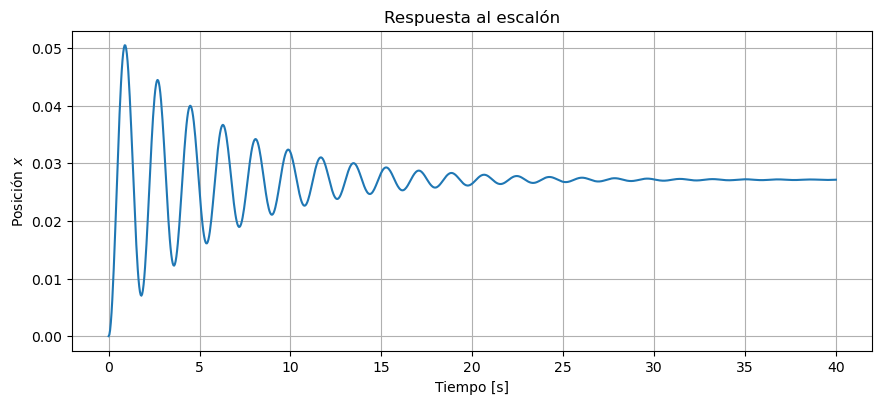

In [22]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(t,y)
ax.set_title('Respuesta al escalón')
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Posición $x$');
ax.grid()

## Simulación No-Lineal

Primero debemos definir el sistema no lineal en una función para que después podamos integrarlo con los métodos de integración del paquete scipy (otro paquete más de Python).

In [23]:
def resorte_no_lineal(t, x, b=1, m=3, K=2, g=9.8, step_amp=1):
    F=1+step_amp # Hacemos la entrada igual a 2 ya que al sistema lineal le aplicamos 
                 # un escalón unitario sobre el punto de trabajo que era F=1
    x1,x2 = x
    dx1 = -b/m*x1-K/m*x2**3+F/m+g
    dx2 = x1
    return dx1, dx2

Para comenzar necesitamos también los valores numéricos de las condiciones iniciales

In [24]:
x0 = np.float64(sol1[x1].subs([(b,1),(K,2),(m,3),(g,9.8)])), np.float64(sol1[x2].subs([(b,1),(K,2),(m,3),(g,9.8)]))
x0

In [25]:
import scipy.integrate as integ
tspan = (0, 40)
t1= np.linspace(*tspan, 1000)

def simulate():
    r = integ.solve_ivp(resorte_no_lineal, tspan, x0, t_eval=t1)
    return r.y

x1,x2 = simulate()

Ahora veamos los resultados de la simulación del sistema no lineal

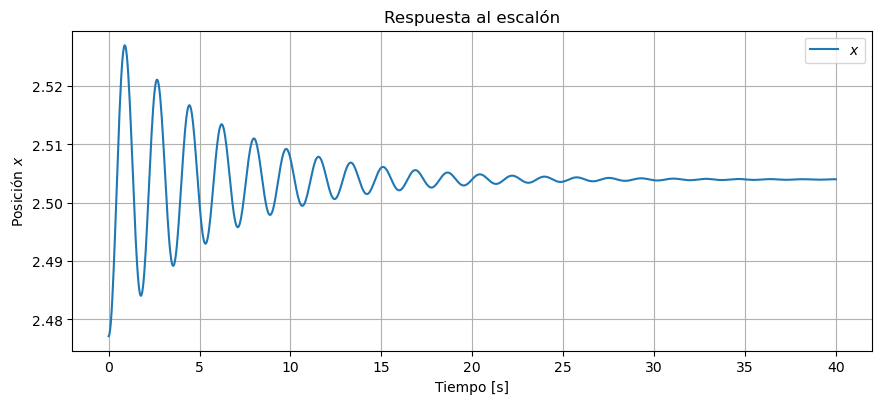

In [26]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(t1,x2, label='$x$')
ax.set_title('Respuesta al escalón')
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Posición $x$')
ax.legend()
ax.grid();

Para poder evaluar las diferencias me falta agregarle a la salida del sistema lineal el valor de equilibrio.

In [27]:
yc = y+x0[1]

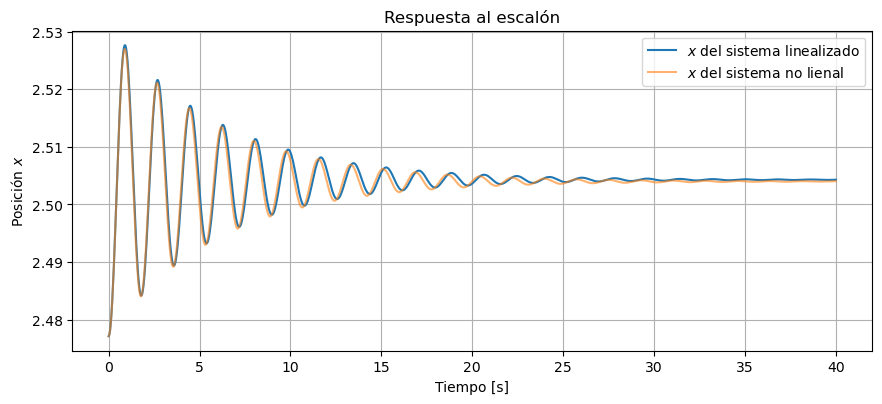

In [28]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(t,yc, label=r'$x$ del sistema linealizado')
ax.plot(t1, x2, label=r'$x$ del sistema no lienal', alpha=0.6)
ax.set_title('Respuesta al escalón')
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Posición $x$')
ax.legend()
ax.grid();

Podemos ver que la respuesta al escalón del sistema lineal y del sistema no lineal dan bastante parecidos.

Dejamos como ejercicio al lector evaluar que sucede si el escalón es más grande (5 o 10 veces más grande).